# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer, StandardScaler

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.shape

(85, 4)


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Convert the type of 'missing_or_unknown' from string to list
feat_info['missing_or_unknown'] = feat_info.missing_or_unknown.str.strip('[]').str.split(',')

In [8]:
# Identify missing or unknown data values and convert them to NaNs in azdias dataset
for i, c in zip(range(len(feat_info)), azdias.columns):
    m_or_u = feat_info.iloc[i].missing_or_unknown
    m_or_u = [int(v) if (v !='X' and v !='XX' and v!='') else v for v in m_or_u]
    azdias[c] = azdias[c].replace(m_or_u,np.nan)

In [9]:
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
p_null = azdias.isna().mean()*100
print('Number of columns with missing data:',sum(p_null != 0))
print('Number of columns without missing data:',sum(p_null == 0))

Number of columns with missing data: 61
Number of columns without missing data: 24


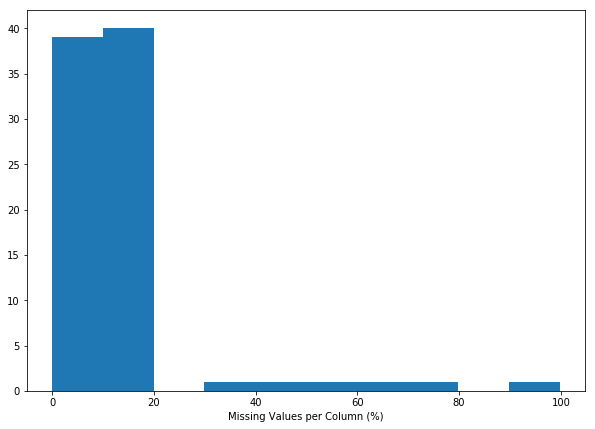

In [12]:
plt.figure(figsize=(10,7))
plt.xlabel('Missing Values per Column (%)')
plt.hist(p_null);

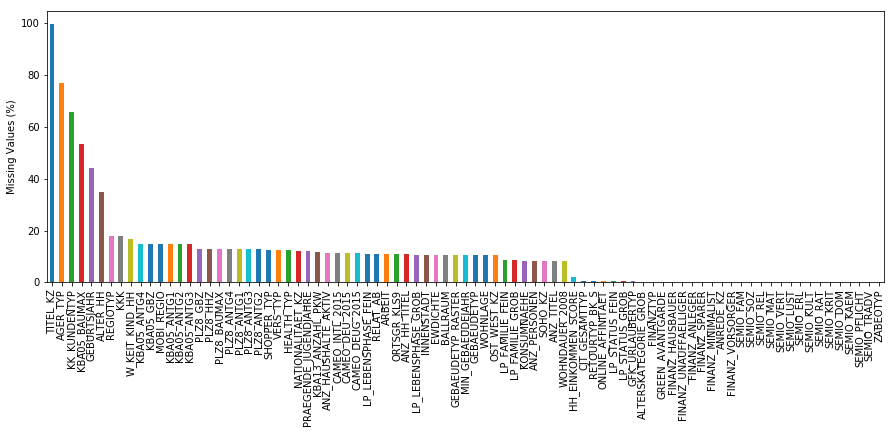

In [13]:
plt.figure(figsize=(15,5))
plt.ylabel('Missing Values (%)')
p_null.sort_values(ascending=False).plot('bar');

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Remove columns with 30%+ missing data
outlier_cols = azdias.columns[p_null > 30].tolist()
azdias.drop(columns=outlier_cols,inplace=True)
print('Dropped columns:',', '.join(outlier_cols))

Dropped columns: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX


In [15]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 61 columns with missing values, and 24 columns without missing values. The proportion of missing values for the majority of the columns is less than 20%. 
However, they’re some outlier columns with more than 30% of its data being missing. I decided to remove these columns which are:

TITEL_KZ (99% missing values) - AGER_TYP (77% missing values) - KK_KUNDENTYP (65% missing values) - KBA05_BAUMAX (53% missing values) - GEBURTSJAHR (44% missing values) - ALTER_HH (35% missing values)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?
null_rows = azdias.isna().sum(axis=1)
print('Number of rows with missing data:',sum(null_rows != 0))
print('Number of rows without missing data:',sum(null_rows == 0))

Number of rows with missing data: 268012
Number of rows without missing data: 623209


In [17]:
null_rows.sort_values(ascending=False)[:10]

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
dtype: int64

In [18]:
null_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_fn = azdias[null_rows < 6].copy()
azdias_mn = azdias[null_rows >= 6].copy()

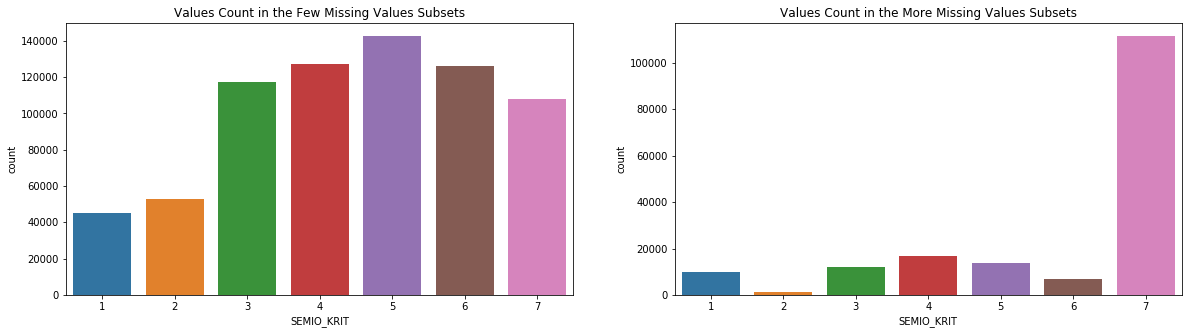

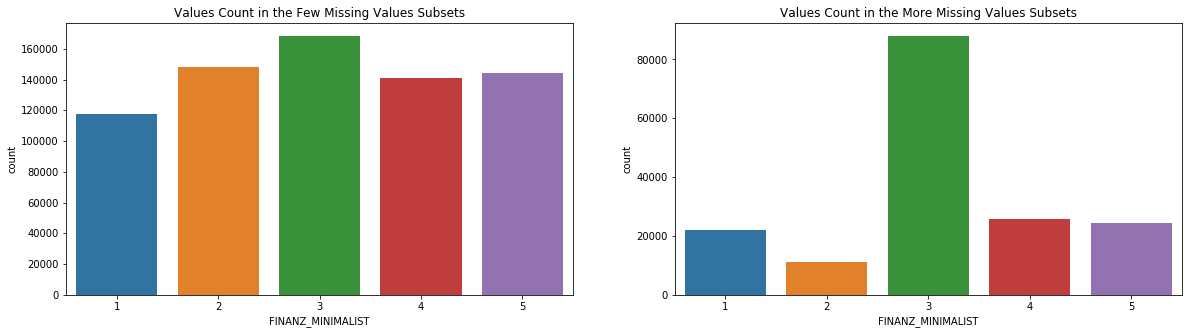

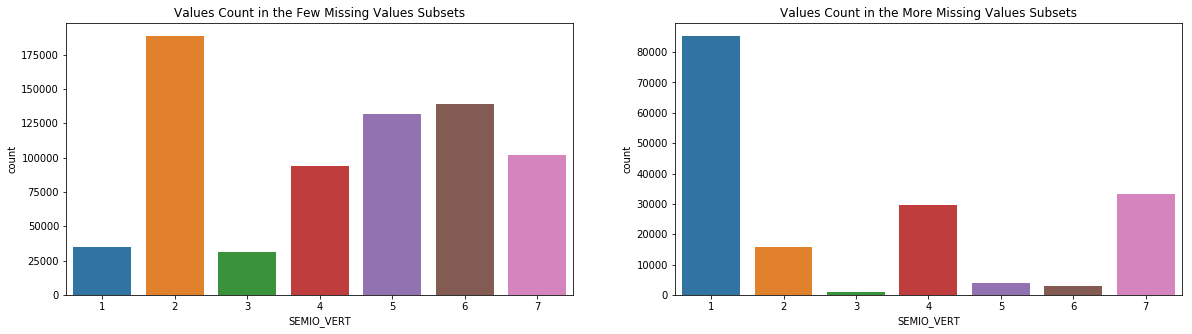

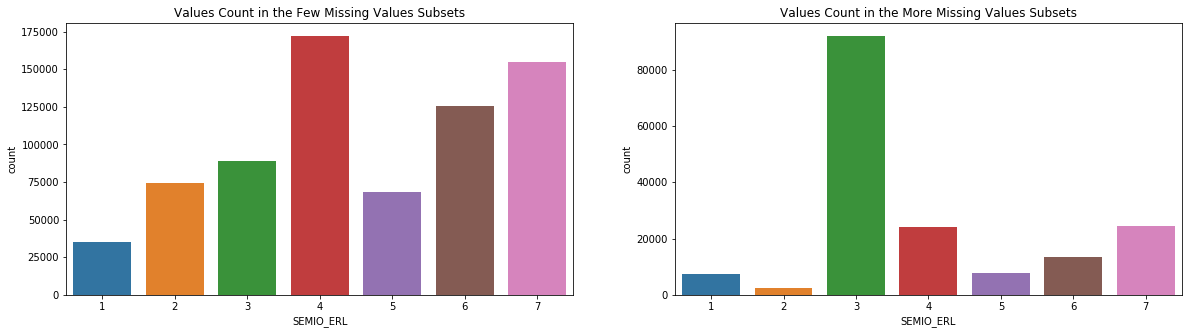

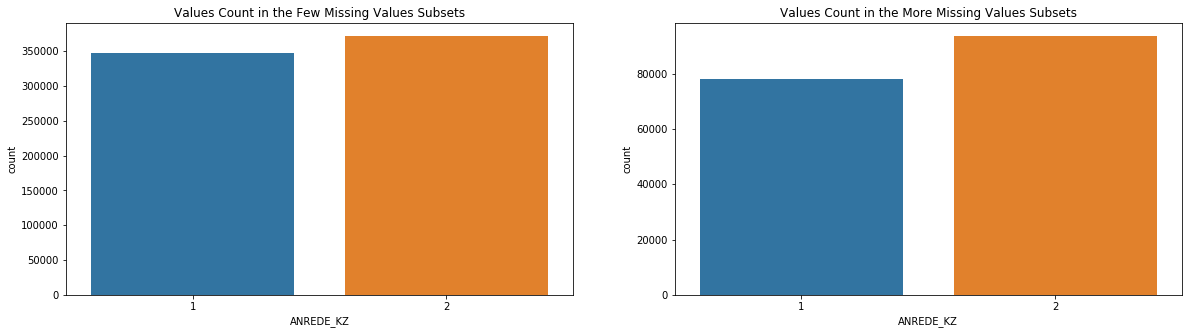

In [20]:
random.seed(10)
random_columns = random.sample(list(p_null[p_null == 0].index),5)

for c in random_columns:
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.title('Values Count in the Few Missing Values Subsets')
    sns.countplot(azdias_fn[c])
    plt.subplot(1,2,2)
    plt.title('Values Count in the More Missing Values Subsets')
    sns.countplot(azdias_mn[c])

#### Discussion 1.1.3: Assess Missing Data in Each Row

30% of the rows have missing data. The average number of missing values per rows is 6.
I had decided to split the dataset into two subsets based on a threshold of 6 missing values per row. Then, I randomly selected 5 columns where there are no missing values to compare its values distribution between the two subsets. The difference between the two was a little bit noticeable.

I have decided to proceed with the subset where there is less than 6 missing values per row.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
#first let's remove the rows related to outlier columns which were dropped from azdias dataset
feat_info_c = feat_info[~feat_info.attribute.isin(outlier_cols)]
feat_info_c.shape

(79, 4)

In [22]:
# How many features are there of each data type?
feat_info_c.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#loop through categorical features and print its level, and list the unique values if it's binary 
cat_feat = feat_info_c[feat_info_c.type == 'categorical']['attribute'].tolist()

for i in cat_feat:
    if azdias_fn[i].nunique() == 2:
        print(i,azdias_fn[i].nunique(),azdias_fn[i].unique(),sep=', ')
    else:
        print(i,azdias_fn[i].nunique(),sep=', ')

ANREDE_KZ, 2, [2 1]
CJT_GESAMTTYP, 6
FINANZTYP, 6
GFK_URLAUBERTYP, 12
GREEN_AVANTGARDE, 2, [0 1]
LP_FAMILIE_FEIN, 11
LP_FAMILIE_GROB, 5
LP_STATUS_FEIN, 10
LP_STATUS_GROB, 5
NATIONALITAET_KZ, 3
SHOPPER_TYP, 4
SOHO_KZ, 2, [ 1.  0.]
VERS_TYP, 2, [  2.   1.  nan]
ZABEOTYP, 6
GEBAEUDETYP, 7
OST_WEST_KZ, 2, ['W' 'O']
CAMEO_DEUG_2015, 9
CAMEO_DEU_2015, 44


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_fn.OST_WEST_KZ.replace(['W','O'],[0,1],inplace=True)

In [25]:
#drop multi-level categorical features
m_levels_cols = []

for i in cat_feat:
    if azdias_fn[i].nunique() > 2:
        m_levels_cols.append(i)

azdias_fn.drop(columns = m_levels_cols,inplace=True)
print('Dropped columns:',', '.join(m_levels_cols))

Dropped columns: CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015


#### Discussion 1.2.1: Re-Encode Categorical Features

The dataset has 18 categorical features, 5 of them are binary categoricals. However, one of binary categorical variables (OST_WEST_KZ) take on non-numeric value, so I had to re-encode the values as numbers.

Also, I have decided to drop the multi-level categorical features (13 features).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_fn.PRAEGENDE_JUGENDJAHRE.unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
         2.,   1.,  12.,  13.,   7.])

In [27]:
azdias_fn.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    168815
8.0     130339
5.0      80064
10.0     78492
3.0      50728
15.0     38221
11.0     31951
9.0      31607
6.0      24650
12.0     22855
4.0      19715
1.0      18924
2.0       7044
13.0      5050
7.0       3805
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [28]:
#engineer new column 'decade'
azdias_fn['decade'] = azdias_fn['PRAEGENDE_JUGENDJAHRE']

#mapping PRAEGENDE_JUGENDJAHRE values to interval variable for decade
decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

#update decade values based on above mapping
azdias_fn['decade'].replace(decade_map,inplace=True)

In [29]:
#engineer new column 'movement'
azdias_fn['movement'] = azdias_fn['PRAEGENDE_JUGENDJAHRE']

#listing PRAEGENDE_JUGENDJAHRE values related to mainstream or avantgarde movement
mainstream = [1,3,5,8,10,12,14]
avantgarde = [2,4,6,7,9,11,13,15]

#replace to binary values: mainstream: 0 , avantgarde: 1
azdias_fn['movement'] = azdias_fn['movement'].replace(mainstream,0).replace(avantgarde,1)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_fn.CAMEO_INTL_2015.unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '33',
       '12', '41', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [31]:
azdias_fn.CAMEO_INTL_2015.value_counts().sort_index()

12     11439
13     23488
14     56623
15     15743
22     29027
23     19147
24     81970
25     36138
31     15498
32      9344
33      8694
34     16913
35      9558
41     84709
43     52027
44     13604
45     24492
51    124571
52     19044
54     42522
55     22016
Name: CAMEO_INTL_2015, dtype: int64

In [32]:
#engineer new column 'wealth'
azdias_fn['wealth'] = azdias_fn['CAMEO_INTL_2015'].astype(float)

#mapping CAMEO_INTL_2015 values to interval variable for wealth
wealth_map = {range(11,16):1, range(21,26):2, range(31,36):3, range(41,46):4, range(51,56):5}

#update wealth values based on above mapping
azdias_fn.wealth = azdias_fn.wealth.apply(lambda x: next((v for k, v in wealth_map.items() if x in k), np.nan))

In [33]:
#engineer new column 'life_stage'
azdias_fn['life_stage'] = azdias_fn['CAMEO_INTL_2015'].astype(float)

#mapping CAMEO_INTL_2015 values to interval variable for life_stage
life_stage_map = {range(11,56,10):1, range(12,56,10):2, range(13,56,10):3, range(14,56,10):4, range(15,56,10):5}

#update life_stage values based on above mapping
azdias_fn.life_stage = azdias_fn.life_stage.apply(lambda x: next((v for k, v in life_stage_map.items() if x in k), np.nan))

#### Discussion 1.2.2: Engineer Mixed-Type Features

Out of the 6 mixed features, two of them (PRAEGENDE_JUGENDJAHRE, and CAMEO_INTL_2015 ) needed special treatment, the rest of the mixed features will be dropped.

PRAEGENDE_JUGENDJAHRE values were mapped into new columns (decade, movement) as follow:

**Decade:**
* 40s: [1,2] -> 1
* 50s: [3,4] -> 2
* 60s: [5,6,7] -> 3
* 70s: [8,9] -> 4
* 80s: [10,11,12,13] -> 5
* 90s: [14,15] -> 6

**Movement:**
* Mainstream: [1,3,5,8,10,12,14] -> 0
* Avantgarde: [2,4,6,7,9,11,13,15] -> 1

CAMEO_INTL_2015 values were mapped into new columns (wealth, life stage) as follow:

**Wealth:**
* Wealthy Households: [11,12,13,14,15] -> 1 
* Prosperous Households: [21,22,23,24,25] -> 2
* Comfortable Households: [31,32,33,34,35] -> 3
* Less Affluent Households: [41,42,43,44,45] -> 4
* Poorer Households: [51,52,53,54,55] -> 5

**Life stage:**
* Pre-Family Couples & Singles: [11,21,31,41,51] -> 1
* Young Couples With Children: [12,22,32,42,52] -> 2
* Families With School Age Children: [13,23,33,43,53] -> 3
* Older Families &  Mature Couples: [14,24,34,44,54] -> 4
* Elders In Retirement: [15,25,35,45,55] -> 5

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
#drop mixed features
mixed_cols = feat_info_c[feat_info_c.type == 'mixed']['attribute'].tolist()
azdias_fn.drop(columns = mixed_cols,inplace=True)

In [35]:
azdias_fn.shape

(719624, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    for i, c in zip(range(len(feat_info)), df.columns):
        m_or_u = feat_info.iloc[i].missing_or_unknown
        m_or_u = [int(v) if (v !='X' and v !='XX' and v!='') else v for v in m_or_u]
        df[c] = df[c].replace(m_or_u,np.nan)
    
    # remove selected columns and rows, ...
    
    #remove columns which have 30%+ null value
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns=outlier_cols)
    
    #remove rows which have 6+ null value
    df = df[df.isna().sum(axis=1) < 6].copy()
    
    # select, re-encode, and engineer column values.
    
    #re-encode OST_WEST_KZ column to numeric values 
    df.OST_WEST_KZ.replace(['W','O'],[0,1],inplace=True)
    
    #remove multi-level categorical features
    feat_info_c = feat_info[~feat_info.attribute.isin(outlier_cols)] 
    cat_feat = feat_info_c[feat_info_c.type == 'categorical']['attribute'].tolist()

    m_levels_cols = []
    for i in cat_feat:
        if df[i].nunique() > 2:
            m_levels_cols.append(i)
            
    df.drop(columns = m_levels_cols,inplace=True)
    
    #engineer new column 'decade'
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE']
    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['decade'].replace(decade_map,inplace=True)

    #engineer new column 'movement'
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE']
    mainstream = [1,3,5,8,10,12,14]
    avantgarde = [2,4,6,7,9,11,13,15]
    df['movement'] = df['movement'].replace(mainstream,0).replace(avantgarde,1)
    
    #engineer new column 'wealth'
    df['wealth'] = df['CAMEO_INTL_2015'].astype(float)
    wealth_map = {range(11,16):1, range(21,26):2, range(31,36):3, range(41,46):4, range(51,56):5}
    df.wealth = df.wealth.apply(lambda x: next((v for k, v in wealth_map.items() if x in k), np.nan))
    
    #engineer new column 'life_stage'
    df['life_stage'] = df['CAMEO_INTL_2015'].astype(float)
    life_stage_map = {range(11,56,10):1, range(12,56,10):2, range(13,56,10):3, range(14,56,10):4, range(15,56,10):5}
    df.life_stage = df.life_stage.apply(lambda x: next((v for k, v in life_stage_map.items() if x in k), np.nan))
    
    #remove columns which are mixed type
    mixed_cols = feat_info_c[feat_info_c.type == 'mixed']['attribute'].tolist()
    df.drop(columns = mixed_cols,inplace=True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_fn.isna().sum().sum()

185269

In [38]:
#apply imputation to the dataset
imputer = Imputer(strategy='median')
azdias_imputed = imputer.fit_transform(azdias_fn)

#convert to dataframe
azdias_imputed = pd.DataFrame(azdias_imputed,columns=azdias_fn.columns)
azdias_imputed.isna().sum().sum()

0

In [39]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_imputed)
azdias_scaled = scaler.transform(azdias_imputed)

azdias_scaled = pd.DataFrame(azdias_scaled,columns= azdias_imputed.columns)

In [40]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.741337,0.967618,-1.517013,1.580959,-1.051251,1.514759,1.045335,1.331721,-0.539090,1.057930,...,0.400206,1.430590,0.569719,-0.187806,-0.143965,0.672332,1.160866,-0.539090,1.163501,-1.256628
1,0.200259,0.967618,-1.517013,0.902619,-1.772031,-0.544028,0.318260,1.331721,1.854978,1.057930,...,-0.971265,0.399436,0.569719,-0.187806,-0.143965,-0.806282,1.160866,1.854978,-0.885448,0.755365
2,0.200259,-1.033466,0.686636,0.224279,0.390308,-1.230290,0.318260,-0.845814,-0.539090,1.057930,...,0.400206,-0.631719,-0.329565,0.821043,0.291999,1.411639,-0.215234,-0.539090,0.480518,0.084701
3,-1.741337,0.967618,-0.047914,-1.132401,1.111087,-0.544028,-0.408814,1.331721,-0.539090,1.057930,...,0.400206,1.430590,1.469002,-1.196654,-1.015893,-0.066975,-1.591335,-0.539090,1.163501,0.755365
4,-0.770539,0.967618,-1.517013,1.580959,-1.772031,1.514759,1.045335,-0.119969,-0.539090,-0.279248,...,-0.971265,1.430590,1.469002,0.821043,0.291999,-0.066975,0.472816,-0.539090,-0.885448,-0.585964


### Discussion 2.1: Apply Feature Scaling

Before I apply feature scaling, I decided to apply imputation to the 185,269 null values, using median.
Then I applied feature scaling by using StandardScaler.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(25, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.tight_layout()

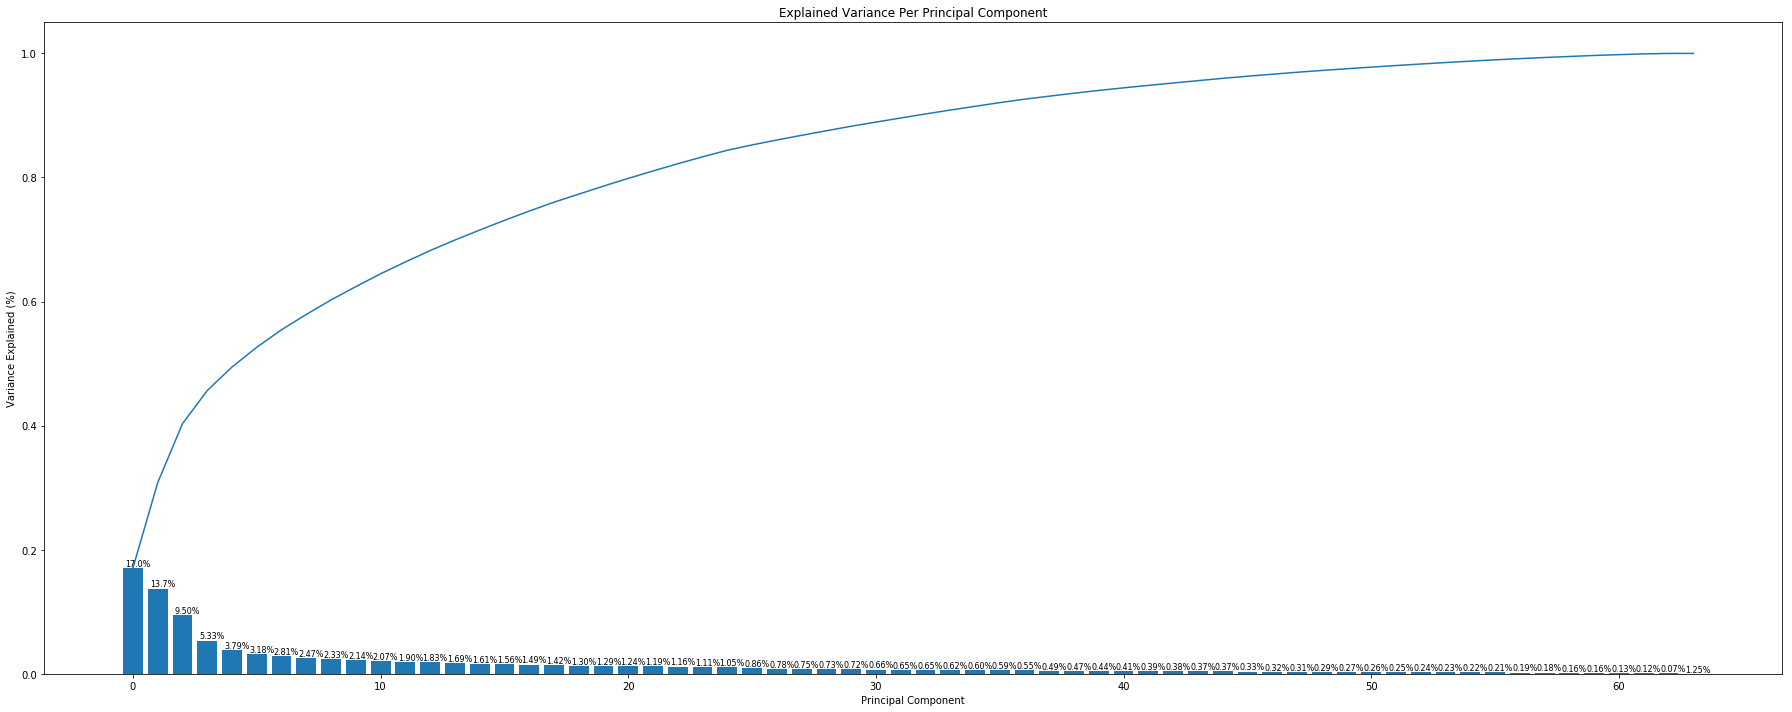

In [43]:
scree_plot(pca)

In [44]:
#find the number of principal components where the cumulative variance explained is >= 90%
for i in range(1,65):
    var = pca.explained_variance_ratio_[:i].sum()
    if var > .90:
        print('With {} principal components, the cumulative ratio of variance explained is {:,.2f}%'.format(i,var*100))
        break

With 33 principal components, the cumulative ratio of variance explained is 90.24%


In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(33)

pca.fit(azdias_scaled)
azdias_reduced = pca.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Initially I applied PCA without setting any parameters. The pca results showed that 90% of the variance is explained with 33 principal components, which is half the number of features in the dataset. Based on that, I have decided to retain 33 principal components for the next step.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

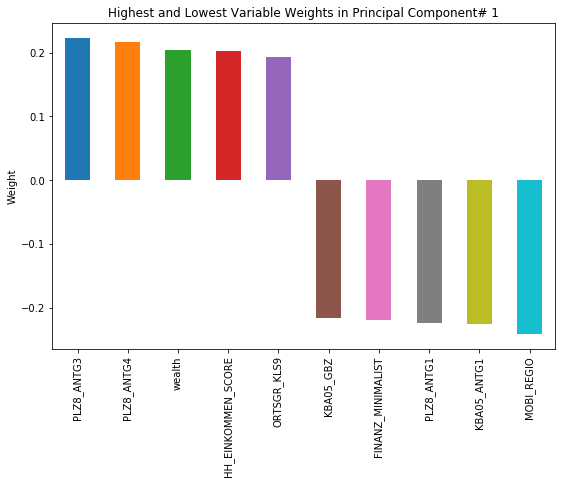

In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def comp_weights(comp_n):
    c_df = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_scaled.columns).iloc[comp_n-1]
    highest = c_df.sort_values(ascending=False)[:5]
    lowest = c_df.sort_values(ascending=False)[-5:]
    concat = pd.concat([highest,lowest])
    plt.figure(figsize=(9, 6))
    plt.title('Highest and Lowest Variable Weights in Principal Component# {}'.format(comp_n))
    plt.ylabel('Weight')
    concat.plot('bar');

comp_weights(1)

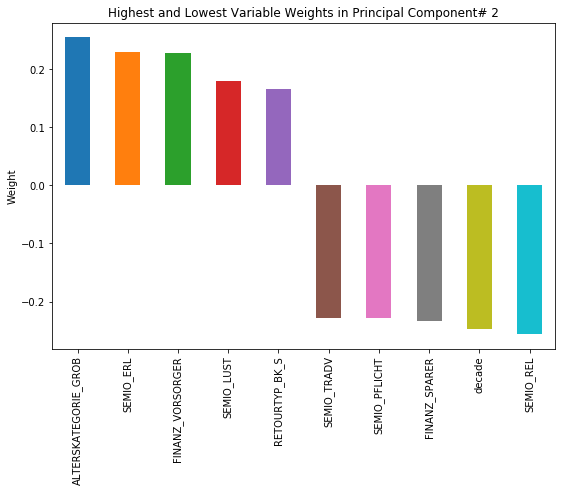

In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weights(2)

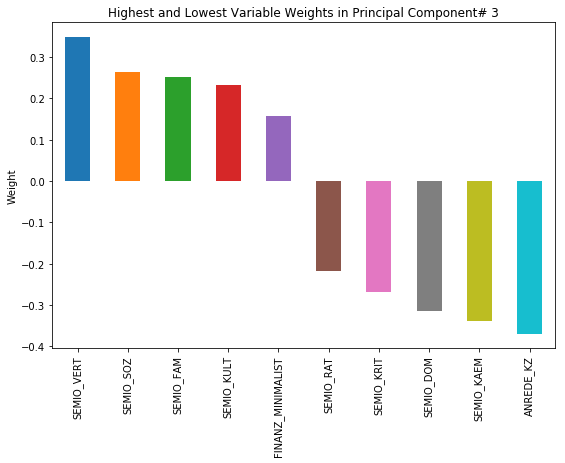

In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weights(3)

### Discussion 2.3: Interpret Principal Components

The first principal component is related to family and houses size, and wealth. It's showing positive correlation between house/family size & wealth. Also, it's showing that as the estimated household net income increases, the number of smaller houses decreases.

The second principal component is related to age, personality, financial typology. For example, it's showing positive correlation between age and being financially prepared. Also, it's showing negative correlation between being an event-oriented person, and traditionally-minded.

The third principal component is mainly about personality typology. It's showing strong relationship between being dreamful, and family minded person. Also, it's showing strong relationship between being rational, and critical-minded person.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

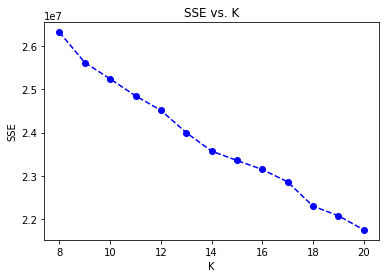

In [50]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(8,21))

for center in centers:
    scores.append(get_kmeans_score(azdias_reduced, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [49]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=14)
model = kmeans.fit(azdias_reduced)
labels = model.predict(azdias_reduced)

### Discussion 3.1: Apply Clustering to General Population

I tried to follow elbow method to determine the optimal number of clusters. Although the graph did not really show an obvious "elbow", I decided to go with 14 clusters because that's where the decrease in SSE started to become small.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [50]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#preprocessing
customers = clean_data(customers)

#imputation
customers_imputed = imputer.transform(customers)

#scaling
customers_scaled = scaler.transform(customers_imputed)

#pca
customers_reduced = pca.transform(customers_scaled)

#cluster predictions
customers_pred = model.predict(customers_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

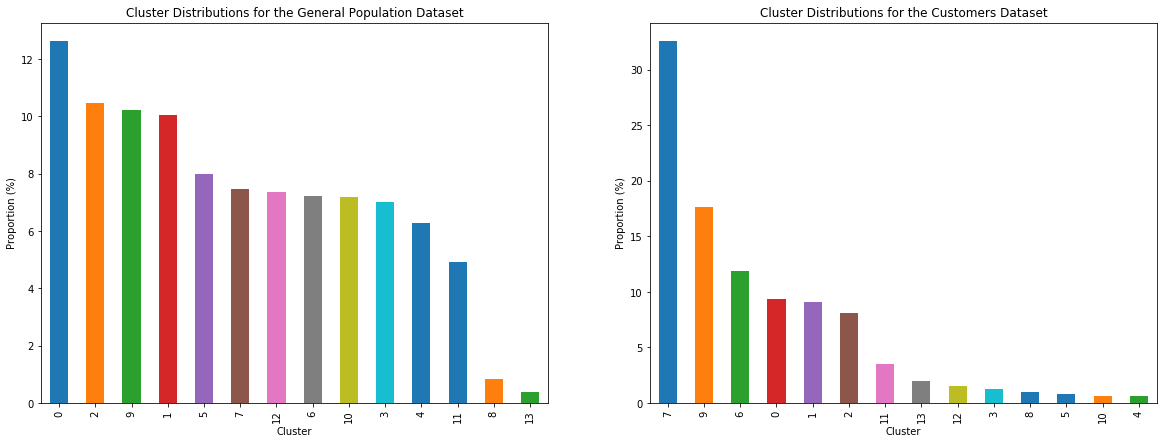

In [52]:
#Compute the proportion
gen_prop = pd.Series(labels).value_counts(normalize=True)*100
cust_prop = pd.Series(customers_pred).value_counts(normalize=True)*100

#plot it
plt.figure(figsize=(20,7))

#general population dataset
plt.subplot(1,2,1)
plt.xlabel('Cluster')
plt.ylabel('Proportion (%)')
plt.title('Cluster Distributions for the General Population Dataset')
gen_prop.plot.bar()

#customers dataset
plt.subplot(1,2,2)
plt.xlabel('Cluster')
plt.ylabel('Proportion (%)')
plt.title('Cluster Distributions for the Customers Dataset')
cust_prop.plot.bar();

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_7 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[7]))
pd.Series(data = centroid_7, index = azdias_imputed.columns)

ALTERSKATEGORIE_GROB        3.304501
ANREDE_KZ                   1.052487
FINANZ_MINIMALIST           4.832456
FINANZ_SPARER               1.629440
FINANZ_VORSORGER            4.195174
FINANZ_ANLEGER              1.514534
FINANZ_UNAUFFAELLIGER       2.164089
FINANZ_HAUSBAUER            1.922870
GREEN_AVANTGARDE            0.988182
HEALTH_TYP                  2.089983
RETOURTYP_BK_S              3.954658
SEMIO_SOZ                   4.880963
SEMIO_FAM                   4.825437
SEMIO_REL                   3.771431
SEMIO_MAT                   3.902330
SEMIO_VERT                  6.199462
SEMIO_LUST                  5.246415
SEMIO_ERL                   4.113920
SEMIO_KULT                  4.907680
SEMIO_RAT                   2.700099
SEMIO_KRIT                  3.167982
SEMIO_DOM                   3.347519
SEMIO_KAEM                  2.613006
SEMIO_PFLICHT               3.170238
SEMIO_TRADV                 3.134708
SOHO_KZ                     0.000008
VERS_TYP                    1.545355
A

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_5 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[5]))
pd.Series(data = centroid_5, index = azdias_imputed.columns)

ALTERSKATEGORIE_GROB        1.783141
ANREDE_KZ                   0.954448
FINANZ_MINIMALIST           1.882080
FINANZ_SPARER               4.372179
FINANZ_VORSORGER            2.085513
FINANZ_ANLEGER              3.568824
FINANZ_UNAUFFAELLIGER       3.760487
FINANZ_HAUSBAUER            3.621225
GREEN_AVANTGARDE            0.122753
HEALTH_TYP                  2.341179
RETOURTYP_BK_S              2.720732
SEMIO_SOZ                   6.828995
SEMIO_FAM                   6.754693
SEMIO_REL                   6.314598
SEMIO_MAT                   5.084770
SEMIO_VERT                  6.095323
SEMIO_LUST                  2.848536
SEMIO_ERL                   2.101851
SEMIO_KULT                  6.943002
SEMIO_RAT                   4.128008
SEMIO_KRIT                  2.749447
SEMIO_DOM                   2.814849
SEMIO_KAEM                  2.380041
SEMIO_PFLICHT               5.721464
SEMIO_TRADV                 4.901703
SOHO_KZ                    -0.000004
VERS_TYP                    1.505872
A

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 7 is overrepresented in the customer dataset compared to the general population, and cluster 5 is underrepresented. People in cluster 7 are older than people in cluster 5. Also people who are part of cluster 7 tend to be living in an upper middle class neighborhood, where people in cluster 5 are living in a lower middle class neighborhood. Additionally, the community unemployment share for people in cluster 7 is lower than people in cluster 5. Overall, people in cluster 7 have more wealth compared to people in cluster 5.